In [1]:
import os 
import matplotlib.pyplot as plt 
import cv2
import numpy as np  
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers 
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = "Datasets/Mri_classifier"
categories  = ["Mri","Not_Mri"]
data = []
labels = []
image_size = 128


In [3]:
type(data)


list

In [4]:
for category in categories:
    
    folder_path = os.path.join(dataset_path,category)
    label = categories.index(category)
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path,image_name)

        #read the image in grayscale
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

        if image is None:
            continue
        else:
            # Resize the image to the target size
            image = cv2.resize(image, (image_size, image_size))
            # Normalize pixel values to range [0, 1]
            image = image / 255.0
        data.append(image)
        labels.append(label)


In [5]:
data = np.array(data).reshape(-1,image_size,image_size,1)
labels = np.array(labels)
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size= 0.02,random_state=42)

In [6]:
batch_size = 32

datagen = ImageDataGenerator(
    rotation_range= 0,
    shear_range=0,        # Shear transformation
    zoom_range=0,         # Random zoom
    horizontal_flip=False,   # Flip images horizontally
    # fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_test,y_test , batch_size = batch_size)

In [7]:
datagen.fit(X_train)

In [8]:
model = Sequential()

# 🧱 Block 1
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))

# 🧱 Block 2
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# 🧱 Block 3
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# 🧠 Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,697 (6.28 MB)

 Trainable params: 1,645,697 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# optimizer = RMSprop(learning_rate=0.01)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


In [10]:
model.compile(optimizer= optimizer,loss = keras.losses.binary_crossentropy,metrics=["accuracy"])

In [11]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=6,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
mc = ModelCheckpoint(
    filepath = "./bestmodelmriclassifier.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    
)
cd = [es,mc]

In [ ]:
batch_size = 32

train_generator = datagen.flow(X_train,y_train,batch_size = batch_size)

history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks = cd)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7602 - loss: 1.6752

109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7611 - loss: 1.6733 - val_accuracy: 0.9718 - val_loss: 1.1451
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9601 - loss: 1.1464

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9602 - loss: 1.1458 - val_accuracy: 0.9859 - val_loss: 0.9429
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9775 - loss: 0.9324

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9775 - loss: 0.9320 - val_accuracy: 0.9859 - val_loss: 0.8081
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9862 - loss: 0.7747

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9862 - loss: 0.7744 - val_accuracy: 0.9859 - val_loss: 0.6775
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9873 - loss: 0.6555

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9873 - loss: 0.6553 - val_accuracy: 0.9859 - val_loss: 0.5724
Epoch 6/10
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9893 - loss: 0.5545

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9893 - loss: 0.5540 - val_accuracy: 0.9859 - val_loss: 0.5017
Epoch 7/10
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9884 - loss: 0.4668

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9884 - loss: 0.4665 - val_accuracy: 0.9859 - val_loss: 0.4052
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9915 - loss: 0.3931

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9915 - loss: 0.3930 - val_accuracy: 0.9859 - val_loss: 0.3583
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9928 - loss: 0.3288

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9927 - loss: 0.3288 - val_accuracy: 0.9859 - val_loss: 0.3113
Epoch 10/10
 20/109 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9948 - loss: 0.2936

In [39]:
test_looss,test_acc = model.evaluate(X_test,y_test)
print(f"Test Accuracy :{test_acc*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0111
Test Accuracy :100.00%


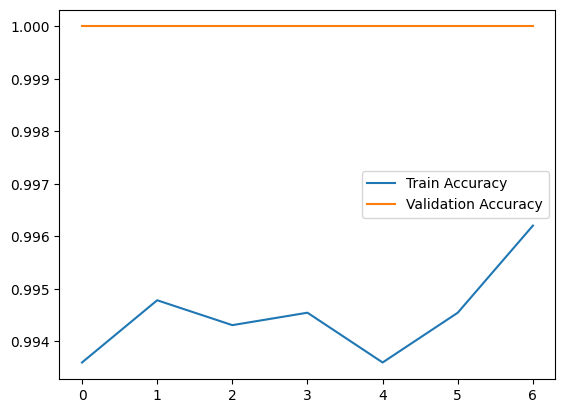

In [40]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

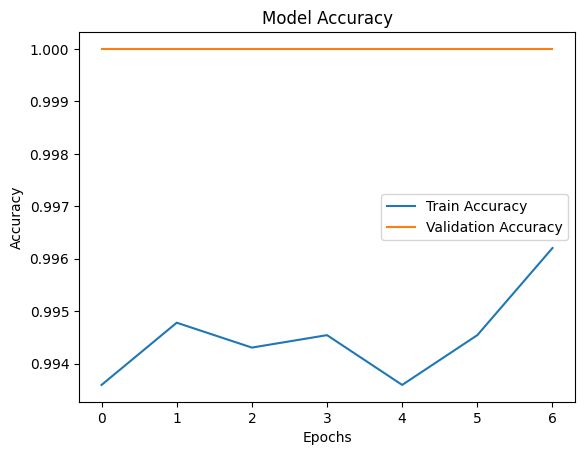

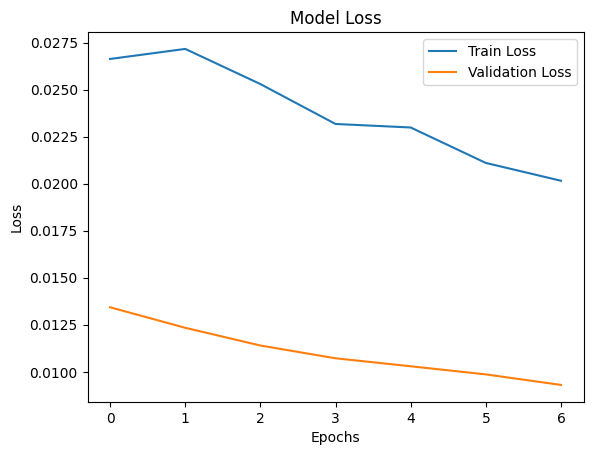

In [41]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()